# Donut plot on a widget tab (ipywidgets)

To answer the following question:   
https://stackoverflow.com/questions/60150375/how-can-i-display-a-matplotlib-pie-chart-in-an-ipywidget-out-widget-i-am-using

Answer based on
 based on https://stackoverflow.com/a/51060721/8508004
 and https://github.com/jupyter-widgets/ipywidgets/issues/1754
 combined with donut plot from 
https://github.com/fomightez/donut_plots_with_subgroups/blob/master/demo_basics_from_df.ipynb .

## Need data for plotting

In [1]:
import pandas as pd
obs = [('A', 1, "frizzled"), 
       ('A', 1, "lethargic"), 
       ('A', 1, "polythene"), 
       ('A', 1, "epic"),
       ('A', 2, "frizzled"), 
       ('A', 2, "lethargic"), 
       ('A', 2, "epic"),
       ('A', 3, "frizzled"), 
       ('A', 3, "lethargic"),
       ('A', 3, "polythene"),
       ('A', 3, "epic"),
       ('A', 3, "bedraggled"),
       ('B', 1, "frizzled"), 
       ('B', 1, "lethargic"),
       ('B', 1, "polythene"),
       ('B', 1, "epic"),
       ('B', 1, "bedraggled"),
       ('B', 1, "moombahcored"),
       ('B', 2, "frizzled"), 
       ('B', 2, "lethargic"),
       ('B', 2, "polythene"),
       ('B', 2, "epic"),
       ('B', 2, "bedraggled"),
       ('C', 1, "frizzled"), 
       ('C', 1, "lethargic"),
       ('C', 1, "polythene"),
       ('C', 1, "epic"),
       ('C', 1, "bedraggled"),
       ('C', 1, "moombahcored"),
       ('C', 1, "zoned"),
       ('C', 1, "erstaz"),
       ('C', 1, "mined"),
       ('C', 1, "liberated"),
       ('C', 2, "frizzled"), 
       ('C', 2, "lethargic"),
       ('C', 2, "polythene"),
       ('C', 2, "epic"),
       ('C', 2, "bedraggled"),
       ('C', 3, "frizzled"), 
       ('C', 3, "lethargic"),
       ('C', 3, "polythene"),
       ('C', 3, "epic"),
       ('C', 3, "bedraggled"),
       ('C', 4, "bedraggled"),
       ('C', 4, "frizzled"), 
       ('C', 4, "lethargic"),
       ('C', 4, "polythene"),
       ('C', 4, "epic"),
       ('C', 5, "frizzled"), 
       ('C', 5, "lethargic"),
       ('C', 5, "polythene"),
       ('C', 5, "epic"),
       ('C', 5, "bedraggled"),
       ('C', 5, "moombahcored")]
labels = ['group', 'subgroup', 'sub-subgroup']
df = pd.DataFrame.from_records(obs, columns=labels)
df.head()

,group,subgroup,sub-subgroup
0,A,1,frizzled
1,A,1,lethargic
2,A,1,polythene
3,A,1,epic
4,A,2,frizzled


# Plot on its own

A donut plot is like a pie graph. Let's make a plot using the data.

In [2]:
## helper functions and settings
import sys
import os
try:
    from pathlib import Path
except ImportError:
    from pathlib2 import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
plot_figure_size = (7,8) # width by height written as `(width,height)`; 
# If you change this to substantial degree, you may also want to 
# adjust text size settings below and possibly turn off plot titles using 
# `include_title=False`in favor of adding your own in post-processing.
outer_ring_radius = 1.3 # radius of the outer ring of the donut plot
inner_ring_radius = outer_ring_radius-0.3 # radius of the inner ring of donut
outer_ring_width=0.3
inner_ring_width=0.4
include_title = True
plot_title = "BREAKDOWN"
title_text_size = 20     # font size for title above plot
plot_text_size = 14 # font size for text in the plot
large_img_size = (14,15) # size to be used with `--large_image` `flag. Width 
# by height written as `(width,height)`
light_color_for_last_in_subgroup = True # Set this to False to reverse the 
# order of the subgroup coloring.
save_plot_name_prefix = "donut_plot"
def sequential_color_maps_generator():
    '''
    generator to yield a never-ending supply of sequential color palettes/ 
    color maps.
    '''
    color_brewer_seq_names = ["Blues", "Reds","Greens","Oranges",
                            "Purples"] #"Greys" looks bad because white is least
    list_of_other_good_sequences = ["teal", "fuchsia", "darkslateblue", "sage", 
                                    "darkviolet",  "crimson", "darkgoldenrod", 
                                    "dodgerblue", "maroon", "darkolivegreen",  
                                    "darkturquoise", "royalblue", "chocolate"]
    np.random.seed(42)
    for col_name in color_brewer_seq_names:
        yield plt.get_cmap(col_name) #`plt.get_cmap` use based on
        # https://matplotlib.org/tutorials/colors/colormaps.html
    for col_name in list_of_other_good_sequences:
        try:
            yield sns.light_palette(col_name, as_cmap=True)
        except ValueError:
            yield sns.light_palette(col_name, as_cmap=True,input="xkcd")
    while True:
        rgb = tuple((np.random.random(size=3) * 1)) # based on 
        # https://stackoverflow.com/a/48793922/8508004
        yield sns.light_palette(rgb, input="rgb", as_cmap=True)
def extract_dataframe(file_name):
    '''
    Takes a file name and using the extension determines how to extract the
    dataframe recorded in it. 
    Returns a pandas dataframe object.
    '''
    extension = Path(file_name).suffix
    if extension.lower() == ".pkl":
        return pd.read_pickle(file_name)
    elif extension.lower() == ".tsv":
        return pd.read_csv(file_name, sep='\t')
    elif extension.lower() == ".csv":
        return pd.read_csv(file_name)
    else:
        sys.stderr.write("\n**ERROR** Cannot determine how dataframe is stored "
            "in '{}'.\nChange the file name extension in the input file to be "
            "`.pkl`, `.tsv`, or `.csv` to indicate\nif dataframe stored "
            "pickled, stored as tab-separated text, or stored as\n"
            "comma-separated text."
            ".\n**EXITING !!**.\n".format(file_name))
        sys.exit(1)
def is_number(s):
    '''
    check if a string can be cast to a float or numeric (integer).
    fixed from https://www.pythoncentral.io/how-to-check-if-a-string-is-a-number-in-python-including-unicode/
    later noted similar code is at https://code-maven.com/slides/python-programming/is-number
    '''
    try:
        float(s)
        return True
    except ValueError:
        pass
    try:
        import unicodedata
        unicodedata.numeric(s)
        return True
    except (TypeError, ValueError):
        pass
    return False

def cast_to_number(s):
    '''
    Cast a string to a float or integer. 
    based on fixed code from https://www.pythoncentral.io/how-to-check-if-a-string-is-a-number-in-python-including-unicode/
    '''
    try:
        number = float(s)
        try:
            number = int(s)
            return number
        except ValueError:
            pass
        return number
    except ValueError:
        pass
    try:
        import unicodedata
        num = unicodedata.numeric(s)
        return num
    except (TypeError, ValueError):
        pass
    return False

def f7(seq):
    '''
    remove duplicates from a list whilst preserving order.
    from https://stackoverflow.com/a/480227/8508004
    '''
    seen = set()
    seen_add = seen.add
    return [x for x in seq if not (x in seen or seen_add(x))]

In [3]:
def donut_plot_with_subgroups_from_dataframe(
    df_file=None, df=None, groups_col=None, subgroups_col=None,
    hilolist = None, 
    sort_on_subgroup_name=False, advance_color_increments=0):
    '''
    Takes a dataframe either as a file or passed directly along some information 
    about columns in the dataframe and makes a donut plot.  The plot is a 
    breakdown of the main groups to subgroups with the main groups in an outer
    ring of the dount plot and the subgroups on the inner ring. The style sought 
    is seen at https://python-graph-gallery.com/163-donut-plot-with-subgroups/ .
    '''
    if df is None:
        # use file extension to decide how to parse dataframe file.
        df = extract_dataframe(df_file)

    # Prepare derivatives of the dataframe that may be needed for delineating 
    # the plotting data
    tc = df[subgroups_col].value_counts()
    total_state_names = tc.index.tolist()
    total_state_size = tc.tolist()
    grouped = df.groupby(groups_col)
    # use `value_counts()` on each group to get the count and name of each state
    list_o_subgroup_names_l = []
    list_o_subgroup_size_l = []
    subgroups_per_group_l = []
    for name,group in grouped:
        dfc = group[subgroups_col].value_counts()
        if sort_on_subgroup_name:
            dfc = group[subgroups_col].value_counts().sort_index()
        #list_o_subgroup_names_l.append(dfc.index.tolist())
        # to make the subgroup names like in the example, incorporate
        # group name to each as well
        list_o_subgroup_names_l.append(["{}.{}".format(name,x) for x in dfc.index.tolist()])
        list_o_subgroup_size_l.append(dfc.tolist())
    
    # Delineate data for the plot:
    group_names= grouped.size().index.tolist()
    group_size= grouped.size().tolist() #len of each groupby grouping
    # flatten each list of lists made above to get the list needed
    subgroup_names=[i for sublt in list_o_subgroup_names_l for i in sublt]
    subgroup_size=[i for sublt in list_o_subgroup_size_l for i in sublt]
    assert len(subgroup_size) == len(subgroup_names)

    # Create colors generator and colors
    colormp = sequential_color_maps_generator()
    [next(colormp) for g in range(advance_color_increments)]#advance prior to 
    # use, if initial skips specified
    colorm_per_grp=[next(colormp) for g in group_names]

    #Set up for plot.
    fig, ax = plt.subplots(figsize=plot_figure_size)
    ax.axis('equal')

    ### First Ring (outside)
    ### This will be the main groups
    labels_with_grp_sz = ["group{}".format(
            x) for x, y in zip(group_names, group_size)]
    mypie, _ = plt.pie(
        group_size, radius=outer_ring_radius, labels=labels_with_grp_sz, 
        textprops={'fontsize': plot_text_size},
        colors=[colormp(0.63) for colormp in colorm_per_grp] )
    plt.setp( mypie, width=outer_ring_width, edgecolor='white')
     
    ### Second Ring (Inside)
    ### This will be the subgroup counting for each group
    list_sub_grp_colors_l  = []
    subgroups_represented = f7(df[subgroups_col].tolist())
    #int_degree = [0.6,0.2]
    if hilolist:
        assert len(hilolist) == len(subgroups_represented), "The list provided "
        "to specify the intensity degree must include all subgroups. Subgroups "
        "are: '{}'.format(subgroups_represented)"
        subgroups_represented = hilolist
    else:
        # Provide feedback on what is being used as high to low intensity list 
        # so user can adjust; using `if __name__ == "__main__"` to customize 
        # note depending if script called from command line.
        sys.stderr.write("Note: No list to specify high to low intensity coloring "
            "provided, and so using '{}',\nwhere leftmost identifer corresponds "
            "to most intense and rightmost is least.\n".format(
            ",".join(str(i) for i in subgroups_represented))) # because subgroups 
        # could be integers as in example from 
        # https://python-graph-gallery.com/163-donut-plot-with-subgroups/, best 
        # to have conversion to string,
        if __name__ == "__main__":
            sys.stderr.write("Look into adding use of the `--hilolist` opition "
                "to specify the order.\n\n")
        else:
            sys.stderr.write("Provide a Python list as `hilolist` when calling "
                "the function to specify the order.\n\n")
    # assign intensity degree settings for each subgroup so consistent among 
    # other groups
    int_degree = np.linspace(0.6, 0.2, num=len(subgroups_represented))
    if not light_color_for_last_in_subgroup:
        int_degree.reverse()
    # determine colors for each subgroup before `plt.pie` step
    for idx,subgroups_l in enumerate(list_o_subgroup_names_l):
        cm = colorm_per_grp[idx]
        grp_colors = [cm(int_degree[subgroups_represented.index(
            int(sgrp.split(".")[1]))]) for sgrp in subgroups_l] # `int(sgrp.split(".")[1])` is
        # to get the subgroup name back to an integer, e.g., `C.3` becomes `3`.
        list_sub_grp_colors_l.append(grp_colors)
    # flatten that list
    sub_grp_colors = [i for sublt in list_sub_grp_colors_l for i in sublt]
    mypie2, _ = plt.pie(
        subgroup_size, radius=inner_ring_radius, labels=subgroup_names, 
        textprops={'fontsize': plot_text_size}, labeldistance=0.7, 
        colors=sub_grp_colors)
    plt.setp( mypie2, width=inner_ring_width, edgecolor='white')
    plt.margins(0,0)

    return ax

Note: No list to specify high to low intensity coloring provided, and so using '1,2,3,4,5',
where leftmost identifer corresponds to most intense and rightmost is least.
Look into adding use of the `--hilolist` opition to specify the order.



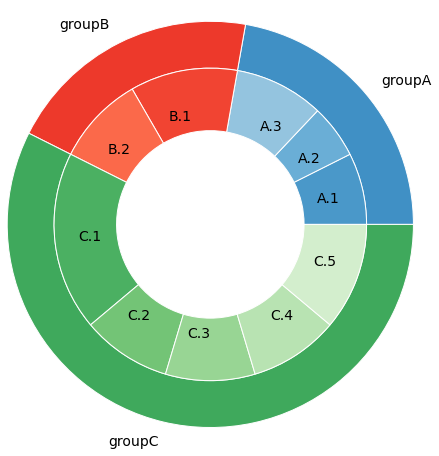

In [4]:
b = donut_plot_with_subgroups_from_dataframe(df=df, groups_col="group",subgroups_col ="subgroup",sort_on_subgroup_name=True);

With plot assigned to a variable we can later call that plot again to display using `.figure`, see [here](https://matplotlib.org/stable/api/figure_api.html).

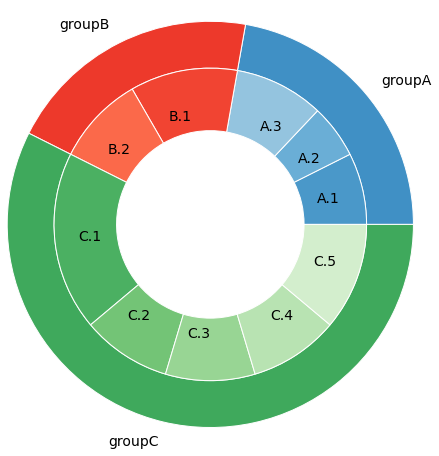

In [5]:
b.figure

# Widgets can have plots on tabs

Based on https://stackoverflow.com/a/51060721/8508004

In [6]:
%matplotlib inline
# based on https://stackoverflow.com/a/51060721/8508004
import matplotlib.pyplot as plt
import pandas as pd
import ipywidgets as widgets
import numpy as np

out1 = widgets.Output()
out2 = widgets.Output()
data1 = pd.DataFrame(np.random.normal(size = 50))
data2 = pd.DataFrame(np.random.normal(size = 100))

tab = widgets.Tab(children = [out1, out2])
tab.set_title(0, 'First')
tab.set_title(1, 'Second')
display(tab)

with out1:
    fig1, axes1 = plt.subplots()
    data1.hist(ax = axes1)
    plt.show(fig1)

with out2:
    fig2, axes2 = plt.subplots()
    data2.hist(ax = axes2)
    plt.show(fig2)

## Combine the donut plot from earlier with widgets

In [7]:
%matplotlib inline
# based on https://stackoverflow.com/a/51060721/8508004
# and https://github.com/jupyter-widgets/ipywidgets/issues/1754
# combined with donut plot from 
# https://github.com/fomightez/donut_plots_with_subgroups/blob/master/demo_basics_from_df.ipynb
import matplotlib.pyplot as plt
import pandas as pd
import ipywidgets as widgets
import numpy as np

out1 = widgets.Output()
out2 = widgets.Output()
data1 = pd.DataFrame(np.random.normal(size = 50))
data2 = pd.DataFrame(np.random.normal(size = 100))

tab = widgets.Tab(children = [out1, out2])
tab.set_title(0, 'First')
tab.set_title(1, 'Second')
display(tab)

with out1:
    #fig1, axes1 = plt.subplots()
    #data1.hist(ax = axes1)
    #plt.show(fig1)
    display(b.figure)

with out2:
    fig2, axes2 = plt.subplots()
    data2.hist(ax = axes2)
    plt.show(fig2)

When researching also saw https://stackoverflow.com/a/48349991/8508004 , but it was much more complex involving widgets inside widgets.

## Specific example with a pie plot

Simpler plot that is more similar to [OP's posted code example](https://stackoverflow.com/q/60150375/8508004) using data from above.

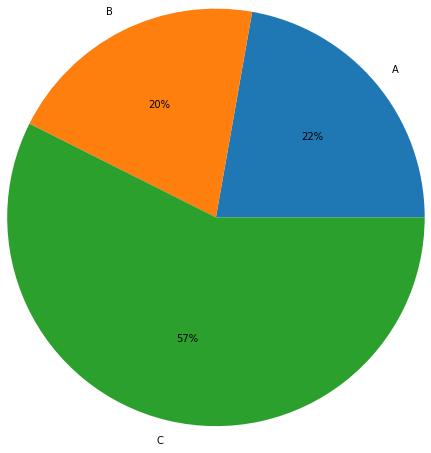

In [8]:
grouped = df.groupby("group")
grouped.size()
group_names= grouped.size().index.tolist()
group_size= grouped.size().tolist()
plt.pie(group_size, labels=group_names,autopct="%0.f%%",radius=2.4);

### Combining pie plot with tab widgets

In [9]:
%matplotlib inline
# based on https://stackoverflow.com/a/51060721/8508004
# and https://github.com/jupyter-widgets/ipywidgets/issues/1754
# combined with donut plot from 
# https://github.com/fomightez/donut_plots_with_subgroups/blob/master/demo_basics_from_df.ipynb
import matplotlib.pyplot as plt
import pandas as pd
import ipywidgets as widgets
import numpy as np

out1 = widgets.Output()
out2 = widgets.Output()
data1 = pd.DataFrame(np.random.normal(size = 50))
data2 = pd.DataFrame(np.random.normal(size = 100))

tab = widgets.Tab(children = [out1, out2])
tab.set_title(0, 'First')
tab.set_title(1, 'Second')
display(tab)

with out1:
    #fig1, axes1 = plt.subplots()
    #data1.hist(ax = axes1)
    #plt.show(fig1)
    grouped = df.groupby("group")
    grouped.size()
    group_names= grouped.size().index.tolist()
    group_size= grouped.size().tolist()
    my_plot  = plt.pie(group_size, labels=group_names,autopct="%0.f%%",radius=2.4)
    plt.show(my_plot)

with out2:
    fig2, axes2 = plt.subplots()
    data2.hist(ax = axes2)
    plt.show(fig2)

-------

A notebook complementary to this one is [here](use_display_with_tabs.ipynb) if it is not clear solely from the example mixed in above in this notebook how you could use `display()` in the `with` blocks, if that was preferred. 

------